# House Prices - Advanced Regression Techniques

## Background &Objectives
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. The dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

Objective:
With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, the project predict the final price of each home.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

## Data Import & Description

In [2]:
train_csv = pd.read_csv('train.csv')
test_csv = pd.read_csv('test.csv')

In [3]:
train_csv['dataset']='1'
test_csv['dataset']='0'
hp_csv=pd.concat([train_csv,test_csv],axis=0)

In [ ]:
train_csv.

In [4]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
test_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [6]:
hp_csv.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,dataset
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,1
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,1
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,1
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,1


In [7]:
y=hp_csv['SalePrice'][hp_csv['dataset']=='1']
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

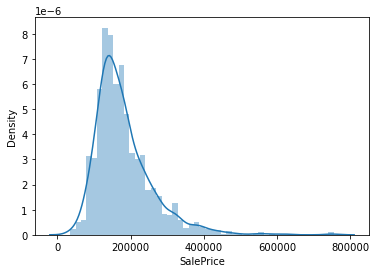

In [8]:
sns.distplot(y)

## Data processing

### missing data

In [9]:
total=hp_csv.isnull().sum().sort_values(ascending=False)
percent=(hp_csv.isnull().sum()/hp_csv.isnull().count()).sort_values(ascending=True)
missingdata=pd.concat([total,percent],axis=1,keys=['total','percent'])
missingdata=missingdata[missingdata['total']>0]

In [10]:
print(missingdata)

              total   percent
PoolQC         2909  0.996574
MiscFeature    2814  0.964029
Alley          2721  0.932169
Fence          2348  0.804385
SalePrice      1459  0.499829
FireplaceQu    1420  0.486468
LotFrontage     486  0.166495
GarageYrBlt     159  0.054471
GarageQual      159  0.054471
GarageFinish    159  0.054471
GarageCond      159  0.054471
GarageType      157  0.053786
BsmtCond         82  0.028092
BsmtExposure     82  0.028092
BsmtQual         81  0.027749
BsmtFinType2     80  0.027407
BsmtFinType1     79  0.027064
MasVnrType       24  0.008222
MasVnrArea       23  0.007879
MSZoning          4  0.001370
Functional        2  0.000685
BsmtFullBath      2  0.000685
Utilities         2  0.000685
BsmtHalfBath      2  0.000685
BsmtFinSF1        1  0.000343
GarageCars        1  0.000343
GarageArea        1  0.000343
Electrical        1  0.000343
TotalBsmtSF       1  0.000343
Exterior2nd       1  0.000343
Exterior1st       1  0.000343
BsmtUnfSF         1  0.000343
SaleType  

In [11]:
missd_name=list(missingdata.index)
object_list=[]
non_object_list=[]
for i in missd_name:
    if hp_csv[i].dtype==object:
        object_list.append(i)
    else:
        non_object_list.append(i)
print("object_list:",object_list)
print("non_object_list:",non_object_list)

object_list: ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageQual', 'GarageFinish', 'GarageCond', 'GarageType', 'BsmtCond', 'BsmtExposure', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1', 'MasVnrType', 'MSZoning', 'Functional', 'Utilities', 'Electrical', 'Exterior2nd', 'Exterior1st', 'SaleType', 'KitchenQual']
non_object_list: ['SalePrice', 'LotFrontage', 'GarageYrBlt', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2']


In [12]:
for i in object_list:
    hp_csv[i].fillna('None',inplace=True)

In [13]:
for i in non_object_list[2:]:
    hp_csv[i].fillna(0,inplace=True)

For those over 40% missing values,it means that it can be deleted.
Therefore, 'PoolQC','MiscFeature','Alley','Fence', and 'FireplaceQu' should be deleted.

In [14]:
hp_new=hp_csv.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],axis=1)

In [15]:
hp_csv['LotFrontage']=hp_csv.groupby(['Neighborhood']).transform(lambda x: x.fillna(x.mean()))

In [16]:
hp_csv['LotFrontage']=hp_csv['LotFrontage'].astype(int)

### Variable processing and encoding 

In [17]:
full_name=list(hp_csv.columns)
object_full_list=[]
nonobject_full_list=[]
for i in full_name:
    if hp_csv[i].dtype==object:
        object_full_list.append(i)
    else:
        nonobject_full_list.append(i)
print("object_list:",object_full_list)
print("nonobject_list:",nonobject_full_list)

object_list: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'dataset']
nonobject_list: ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'Gar

In [18]:
for i in object_full_list+non_object_list:
    lbl=LabelEncoder()
    lbl.fit(list(hp_csv[i].values))
    hp_csv[i]=lbl.transform(list(hp_csv[i].values))

In [19]:
hp_csv.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,dataset
0,1,60,4,0,8450,1,1,3,3,0,...,3,4,1,0,2,2008,9,4,412,1
1,2,20,4,1,9600,1,1,3,3,0,...,3,4,1,0,5,2007,9,4,339,1
2,3,60,4,2,11250,1,1,0,3,0,...,3,4,1,0,9,2008,9,4,442,1
3,4,70,4,3,9550,1,1,0,3,0,...,3,4,1,0,2,2006,9,0,194,1
4,5,60,4,4,14260,1,1,0,3,0,...,3,4,1,0,12,2008,9,4,494,1


In [20]:
from sklearn.preprocessing import MinMaxScaler
hp_new2=hp_csv.drop(['Id','SalePrice'],axis=1)
col_name=list(hp_new2.columns)
scaler=MinMaxScaler().fit(hp_new2[col_name])
hp_new2[col_name]=scaler.transform(hp_new2[col_name])
hp_new2

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,dataset
0,0.235294,0.8,0.000000,0.033420,1.0,0.5,1.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.25,0.000000,0.090909,0.50,1.0,0.8,1.0
1,0.000000,0.8,0.000343,0.038795,1.0,0.5,1.0,1.0,0.0,0.5,...,0.0,1.0,1.0,0.25,0.000000,0.363636,0.25,1.0,0.8,1.0
2,0.235294,0.8,0.000685,0.046507,1.0,0.5,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.25,0.000000,0.727273,0.50,1.0,0.8,1.0
3,0.294118,0.8,0.001028,0.038561,1.0,0.5,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.25,0.000000,0.090909,0.00,1.0,0.0,1.0
4,0.235294,0.8,0.001371,0.060576,1.0,0.5,0.0,1.0,0.0,0.5,...,0.0,1.0,1.0,0.25,0.000000,1.000000,0.50,1.0,0.8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0.823529,1.0,0.998629,0.002973,1.0,0.5,1.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.25,0.000000,0.454545,0.00,1.0,0.8,0.0
1455,0.823529,1.0,0.998972,0.002776,1.0,0.5,1.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.25,0.000000,0.272727,0.00,1.0,0.0,0.0
1456,0.000000,0.8,0.999315,0.087406,1.0,0.5,1.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.25,0.000000,0.727273,0.00,1.0,0.0,0.0
1457,0.382353,0.8,0.999657,0.042726,1.0,0.5,1.0,1.0,0.0,1.0,...,0.0,1.0,0.5,0.75,0.041176,0.545455,0.00,1.0,0.8,0.0


In [21]:
full_col=list(hp_new2.columns)
train_cc=hp_new2[full_col]
skew_cc=train_cc.skew(axis=0)
skew=skew_cc[abs(skew_cc)>0.75]
skew=skew.to_frame(name='skewness')
print(skew)
print(skew.index)

                skewness
MSSubClass      1.376165
MSZoning       -2.575195
LotArea        12.829025
Street        -15.508104
LandContour    -3.118295
Utilities      33.990952
LotConfig      -1.196901
LandSlope       4.977715
Condition1      2.984648
Condition2     12.066294
BldgType        2.193388
RoofStyle       1.554106
RoofMatl        8.712245
MasVnrArea      1.557110
ExterQual      -1.802335
ExterCond      -2.499003
BsmtCond       -2.864057
BsmtExposure   -1.115430
BsmtFinType2   -3.045893
BsmtFinSF2      3.478350
Heating        12.084999
CentralAir     -3.460801
Electrical     -3.049382
1stFlrSF        1.470360
2ndFlrSF        0.862118
LowQualFinSF   12.094977
GrLivArea       1.270010
BsmtHalfBath    3.933616
KitchenAbvGr    4.304467
TotRmsAbvGrd    0.758757
Functional     -3.820689
GarageQual     -3.075732
GarageCond     -3.597639
PavedDrive     -2.980616
WoodDeckSF      1.843380
OpenPorchSF     2.536417
EnclosedPorch   4.005950
3SsnPorch      11.381914
ScreenPorch     3.948723


In [22]:
for i in list(skew.index):
    hp_csv[i]=np.log1p(hp_csv[i])

In [23]:
full_col=list(hp_csv.columns)
train_cc=hp_csv[full_col]
skew_cc=train_cc.skew(axis=0)
skew=skew_cc[abs(skew_cc)>0.75]
skew=skew.to_frame(name='skewness')
print(skew)
print(skew.index)

                skewness
MSZoning       -3.749173
Street        -15.508104
LandContour    -3.528663
Utilities      32.722387
LotConfig      -1.353095
LandSlope       4.486542
Condition1     -0.959142
Condition2     -4.781968
BldgType        1.971066
RoofStyle       1.294681
RoofMatl        8.254887
ExterQual      -3.049371
ExterCond      -3.182679
BsmtCond       -3.320867
BsmtExposure   -1.457024
BsmtFinType2   -3.951148
BsmtFinSF2      2.515870
Heating         9.592262
CentralAir     -3.460801
Electrical     -3.171859
LowQualFinSF    8.562091
BsmtHalfBath    3.776703
KitchenAbvGr    3.522161
Functional     -4.999907
GarageQual     -3.528110
GarageCond     -4.319114
PavedDrive     -3.081842
EnclosedPorch   1.962089
3SsnPorch       8.829794
ScreenPorch     2.947420
PoolArea       15.006047
PoolQC        -22.874990
Fence          -2.669848
MiscFeature     4.499531
MiscVal         5.216665
SaleType       -4.441811
SaleCondition  -3.259505
Index(['MSZoning', 'Street', 'LandContour', 'Utili

In [24]:
hp_new2.describe()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,dataset
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,0.218457,0.793765,0.500000,0.041450,0.995889,0.492806,0.649195,0.925659,0.000856,0.763960,...,0.002815,0.997716,0.873416,0.266444,0.002990,0.473917,0.448184,0.928705,0.755807,0.500171
std,0.250104,0.171681,0.288824,0.036865,0.063996,0.130046,0.469907,0.234797,0.027755,0.401118,...,0.044580,0.042691,0.272844,0.090853,0.033377,0.246797,0.328741,0.208846,0.215648,0.500086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.800000,0.250000,0.028877,1.000000,0.500000,0.000000,1.000000,0.000000,0.500000,...,0.000000,1.000000,1.000000,0.250000,0.000000,0.272727,0.250000,1.000000,0.800000,0.000000
50%,0.176471,0.800000,0.500000,0.038108,1.000000,0.500000,1.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,0.250000,0.000000,0.454545,0.500000,1.000000,0.800000,1.000000
75%,0.294118,0.800000,0.750000,0.048003,1.000000,0.500000,1.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,0.250000,0.000000,0.636364,0.750000,1.000000,0.800000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [89]:
train_new=hp_new2[hp_new2['dataset']==1]
test_new=hp_new2[hp_new2['dataset']==0]

## feature selection and deduction

###  feature importance

In [117]:
lasso=Lasso(alpha=0.001)
lasso.fit(train_real2,y1)

Lasso(alpha=0.001)

In [118]:
F_lasso=pd.DataFrame({'feature importance':lasso.coef_},index=train_real2.columns)

In [119]:
F_lasso.sort_values('feature importance',ascending=False)

,feature importance
OverallQual,0.626693
TotalBsmtSF,0.362898
GrLivArea,0.303136
OverallCond,0.240198
2ndFlrSF,0.231668
...,...
HeatingQC,-0.032205
GarageType,-0.045173
KitchenQual,-0.057844
BsmtQual,-0.058536


In [122]:
F_0=F_lasso[F_lasso['feature importance']==0]
print(F_0.index)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'LandContour',
       'Utilities', 'Condition1', 'Condition2', 'HouseStyle', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'BsmtCond', 'BsmtFinType2', 'Heating', 'Electrical', '1stFlrSF',
       'LowQualFinSF', 'BsmtHalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'GarageYrBlt', 'GarageQual', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'PoolArea', 'PoolQC', 'Fence',
       'MiscFeature', 'MiscVal', 'MoSold', 'SaleType'],
      dtype='object')


In [128]:
F_1=list(F_0.index)
train_features=train_real2.drop(F_1,axis=1)
test_features=test_real.drop(F_1,axis=1)

### K-means

In [27]:
train_real=train_new.drop(['dataset'],axis=1)

In [90]:
test_real = test_new.drop(['dataset'],axis=1)

In [30]:
from sklearn.cluster import KMeans
inertia=[]
list_num_clusters = list(range(1,11))
for num_clusters in list_num_clusters:
    km=KMeans(n_clusters=num_clusters)
    km.fit(train_real)
    inertia.append(km.inertia_)

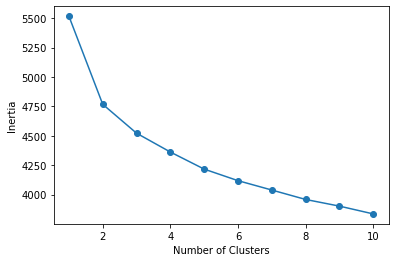

In [31]:
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [32]:
km2=KMeans(n_clusters=3).fit(train_real)
train_real['group']=km2.labels_

In [33]:
train_new2=pd.concat([train_new,train_real['group']],axis=1)

In [34]:
train_new2.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,dataset,group
0,0.235294,0.8,0.000000,0.033420,1.0,0.5,1.0,1.0,0.0,1.0,...,1.0,1.0,0.25,0.0,0.090909,0.50,1.0,0.8,1.0,1
1,0.000000,0.8,0.000343,0.038795,1.0,0.5,1.0,1.0,0.0,0.5,...,1.0,1.0,0.25,0.0,0.363636,0.25,1.0,0.8,1.0,0
2,0.235294,0.8,0.000685,0.046507,1.0,0.5,0.0,1.0,0.0,1.0,...,1.0,1.0,0.25,0.0,0.727273,0.50,1.0,0.8,1.0,1
3,0.294118,0.8,0.001028,0.038561,1.0,0.5,0.0,1.0,0.0,0.0,...,1.0,1.0,0.25,0.0,0.090909,0.00,1.0,0.0,1.0,0
4,0.235294,0.8,0.001371,0.060576,1.0,0.5,0.0,1.0,0.0,0.5,...,1.0,1.0,0.25,0.0,1.000000,0.50,1.0,0.8,1.0,1


In [43]:
from pandas import DataFrame
y_sale=DataFrame({'SalePrice':y})

In [44]:
y_sale

,SalePrice
0,208500.0
1,181500.0
2,223500.0
3,140000.0
4,250000.0
...,...
1455,175000.0
1456,210000.0
1457,266500.0
1458,142125.0


In [46]:
train_new3=pd.concat([train_new2,y_sale],axis=1)
print(train_new3.head())

   MSSubClass  MSZoning  LotFrontage   LotArea  Street  Alley  LotShape  \
0    0.235294       0.8     0.000000  0.033420     1.0    0.5       1.0   
1    0.000000       0.8     0.000343  0.038795     1.0    0.5       1.0   
2    0.235294       0.8     0.000685  0.046507     1.0    0.5       0.0   
3    0.294118       0.8     0.001028  0.038561     1.0    0.5       0.0   
4    0.235294       0.8     0.001371  0.060576     1.0    0.5       0.0   

   LandContour  Utilities  LotConfig  ...  Fence  MiscFeature  MiscVal  \
0          1.0        0.0        1.0  ...    1.0         0.25      0.0   
1          1.0        0.0        0.5  ...    1.0         0.25      0.0   
2          1.0        0.0        1.0  ...    1.0         0.25      0.0   
3          1.0        0.0        0.0  ...    1.0         0.25      0.0   
4          1.0        0.0        0.5  ...    1.0         0.25      0.0   

     MoSold  YrSold  SaleType  SaleCondition  dataset  group  SalePrice  
0  0.090909    0.50       1.0 

In [47]:
group_data=train_new3.groupby(['group']).mean()
group_data['SalePrice']

group
0    152732.001890
1    240521.496610
2    121530.891496
Name: SalePrice, dtype: float64

Difference in sales is obivous so it may be a good clustering
However, too much dimensions ends in 3 clusters might lose a lot of information. 
The target is to predict the housing price so the K-means method is not applicable for predicting housing prices.
Next Steps:
(1) Used PCA to decrease the dimensions
(2) Used models(Regression, Bagging and boosting methods) to predict the housing prices

###  PCA

In [48]:
train_real2=train_real.drop('group',axis=1)

In [49]:
train_real2.shape

(1460, 79)

In [91]:
test_real.shape

(1459, 79)

In [51]:
from sklearn.decomposition import PCA
pca_list=list()
feature_weight_list=list()
for n in range(1,40):
    PCAmod=PCA(n_components=n)
    PCAmod.fit(train_real2)
    pca_list.append(pd.Series({'n':n,'model':PCAmod,
                               'var':PCAmod.explained_variance_ratio_.sum()}))
    abs_feature_values=np.abs(PCAmod.components_).sum(axis=0)
    feature_weight_list.append(pd.DataFrame({
                                'n':n,
                                'features':train_real2.columns,
                                'values':abs_feature_values/abs_feature_values.sum()
}))
pca_df=pd.concat(pca_list,axis=1).T.set_index('n')
pca_df

,model,var
n,,
1,PCA(n_components=1),0.176047
2,PCA(n_components=2),0.253102
3,PCA(n_components=3),0.315185
4,PCA(n_components=4),0.36202
5,PCA(n_components=5),0.402422
6,PCA(n_components=6),0.440148
7,PCA(n_components=7),0.475287
8,PCA(n_components=8),0.507335
9,PCA(n_components=9),0.538172


In [129]:
train_features.columns

Index(['MSZoning', 'Alley', 'LotShape', 'LotConfig', 'LandSlope',
       'Neighborhood', 'BldgType', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofMatl', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', 'CentralAir', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageCond', 'PavedDrive', 'ScreenPorch',
       'YrSold', 'SaleCondition'],
      dtype='object')

In [130]:
from sklearn.decomposition import PCA
pca_list=list()
feature_weight_list=list()
for n in range(1,40):
    PCAmod=PCA(n_components=n)
    PCAmod.fit(train_features)
    pca_list.append(pd.Series({'n':n,'model':PCAmod,
                               'var':PCAmod.explained_variance_ratio_.sum()}))
    abs_feature_values=np.abs(PCAmod.components_).sum(axis=0)
    feature_weight_list.append(pd.DataFrame({
                                'n':n,
                                'features':train_features.columns,
                                'values':abs_feature_values/abs_feature_values.sum()
}))
pca_df=pd.concat(pca_list,axis=1).T.set_index('n')
pca_df

,model,var
n,,
1,PCA(n_components=1),0.205245
2,PCA(n_components=2),0.305934
3,PCA(n_components=3),0.389617
4,PCA(n_components=4),0.441543
5,PCA(n_components=5),0.48987
6,PCA(n_components=6),0.534095
7,PCA(n_components=7),0.575643
8,PCA(n_components=8),0.615387
9,PCA(n_components=9),0.652323


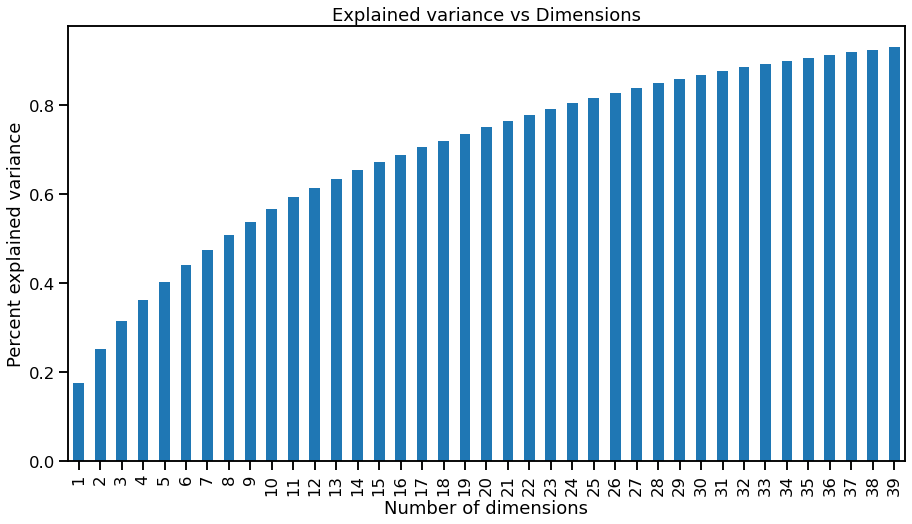

In [52]:
sns.set_context('talk')
plt.figure(figsize=(15, 8))
ax = pca_df['var'].plot(kind='bar')
ax. set(xlabel='Number of dimensions',
       ylabel='Percent explained variance',
       title='Explained variance vs Dimensions');

79 dimensions could be deducted to 35 dimensions, with variances more than 90.6%

In [53]:
pca=PCA(n_components=35)
X_scaled=pca.fit_transform(train_real2)
print(X_scaled)
print(X_scaled.shape)

[[ 0.62139404 -0.09039312 -0.56881117 ... -0.04505445  0.08500836
  -0.13048469]
 [ 0.14268384  0.57654452 -0.32490471 ...  0.06578555 -0.05847321
  -0.14479061]
 [ 0.87281173  0.12776005  0.21598469 ... -0.0675353   0.00393354
  -0.0256786 ]
 ...
 [ 0.0727726  -0.30419109 -0.31129305 ...  0.10830725  0.38508199
   0.02175034]
 [-0.61378183  0.22254815 -0.40579911 ... -0.00675809  0.10073956
   0.26285867]
 [-0.24102832  0.61016369 -0.51363074 ... -0.00328618  0.12384418
   0.13034319]]
(1460, 35)


In [92]:
pca=PCA(n_components=35)
Test_scaled=pca.fit_transform(test_real)
print(Test_scaled.shape)

(1459, 35)


features selections

In [131]:
pca=PCA(n_components=22)
train_f_scaled=pca.fit_transform(train_features)
pca=PCA(n_components=22)
test_f_scaled=pca.fit_transform(test_features)
print(test_f_scaled.shape)

(1459, 22)


## Modelling

We choose  several models and use 5-folds cross-calidation to evaluate these models.
Models include:

LinearRegression
Ridge
Lasso
Random Forrest
Gradient Boosting Tree
Support Vector Regression
Linear Support Vector Regression
ExtraTreesRegressor
XgBoost
Adaboost
GBDT


In [55]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [62]:
y1=np.log1p(y)

In [58]:
X_scaled=pd.DataFrame(X_scaled)

In [59]:
X_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 35 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1460 non-null   float64
 1   1       1460 non-null   float64
 2   2       1460 non-null   float64
 3   3       1460 non-null   float64
 4   4       1460 non-null   float64
 5   5       1460 non-null   float64
 6   6       1460 non-null   float64
 7   7       1460 non-null   float64
 8   8       1460 non-null   float64
 9   9       1460 non-null   float64
 10  10      1460 non-null   float64
 11  11      1460 non-null   float64
 12  12      1460 non-null   float64
 13  13      1460 non-null   float64
 14  14      1460 non-null   float64
 15  15      1460 non-null   float64
 16  16      1460 non-null   float64
 17  17      1460 non-null   float64
 18  18      1460 non-null   float64
 19  19      1460 non-null   float64
 20  20      1460 non-null   float64
 21  21      1460 non-null   float64
 22  

In [60]:
models = {}
models['LR'] = LinearRegression()
models['Ridge'] = Ridge()
models['Lasso']=Lasso(alpha=0.01,max_iter=10000)
models['RF']=RandomForestRegressor()
models['SVR']= SVR()
models['LR']= LinearSVR()
models['Ela']= ElasticNet(alpha=0.001,max_iter=10000)
models['SGD'] = SGDRegressor(max_iter=1000,tol=1e-3)
models['Bay'] = BayesianRidge()
models['KR'] = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
models['Extra'] = ExtraTreesRegressor()
models['XGB'] = XGBRegressor()
models['Ada'] = AdaBoostRegressor()
models['GBDT'] = GradientBoostingRegressor()

In [63]:
kf = KFold(10)
for model in models:
    cv_result = cross_val_score(models[model], X_scaled, y1, cv=kf, scoring="neg_mean_squared_error")
    print('%s model scoring %s，std %s' % (model, 
                                           round(np.sqrt(-cv_result.mean()),4), 
                                           cv_result.std()))

LR model scoring 0.1535，std 0.006914052523403825
Ridge model scoring 0.153，std 0.007007363047927657
Lasso model scoring 0.1956，std 0.008428107648325018
RF model scoring 0.1791，std 0.00619778429454758
SVR model scoring 0.1592，std 0.004861613521901746
Ela model scoring 0.1531，std 0.006963691626275504
SGD model scoring 0.1641，std 0.007061279691485609
Bay model scoring 0.153，std 0.006999910729121719
KR model scoring 0.1508，std 0.006837252265078653
Extra model scoring 0.1731，std 0.006562451583580815
XGB model scoring 0.1674，std 0.006237492230090017
Ada model scoring 0.2084，std 0.0066340950257160036
GBDT model scoring 0.1699，std 0.006902300916498008


In [133]:
kf = KFold(10)
for model in models:
    cv_result = cross_val_score(models[model], train_f_scaled, y1, cv=kf, scoring="neg_mean_squared_error")
    print('%s model scoring %s，std %s' % (model, 
                                           round(np.sqrt(-cv_result.mean()),4), 
                                           cv_result.std()))

LR model scoring 0.1586，std 0.005756513937955612
Ridge model scoring 0.1576，std 0.005755612871255087
Lasso model scoring 0.1896，std 0.0068304335336962585
RF model scoring 0.1755，std 0.006200994363408113
SVR model scoring 0.1646，std 0.005150609663803794
Ela model scoring 0.1578，std 0.005637495521874678
SGD model scoring 0.1655，std 0.006400126804180132
Bay model scoring 0.1576，std 0.005755678516460543
KR model scoring 0.1547，std 0.005626315991468895
Extra model scoring 0.1704，std 0.006770398468848911
XGB model scoring 0.1834，std 0.006579131179972309
Ada model scoring 0.1992，std 0.006792435312461681
GBDT model scoring 0.1693，std 0.006207849002592381


Narrow down to better perfermance models:
Adaboost
RF,Extra
Lasso

Next we do some hyperparameters tuning. First define a gridsearch method.

### Lasso

In [73]:
grid=GridSearchCV(estimator=Lasso(),
                  param_grid=
                  {'alpha':[0.0001,0.00015,0.0002,0.0005,0.01],
                   'max_iter':[10000],
                  'normalize':[True,False]},
                  cv=kf,
                  scoring='neg_mean_squared_error')
grid_result=grid.fit(X_scaled,y1)
print('Lasso best_estimatoris %s,scoring %s'
      %(grid_result.best_params_,
        round(np.sqrt(-1*grid_result.best_score_),4)
     ))

Lasso best_estimatoris {'alpha': 0.0002, 'max_iter': 10000, 'normalize': False},scoring 0.1529


### Bagging Models

In [74]:
bagging_models={'RandomForest':RandomForestRegressor(),
               'ExtraTree':ExtraTreesRegressor()}
bagging_params={'n_estimators':[10,50,100,200,500,800]}

In [75]:
kf=KFold(10)
for model in bagging_models:
    grid=GridSearchCV(estimator=bagging_models[model],
                      param_grid=bagging_params,
                      cv=kf,
                      scoring='neg_mean_squared_error')
    grid_result=grid.fit(X_scaled,y1)
    print('%s model best_estimatoris %s,scoring %s'
      %(model,
        grid_result.best_params_,
        round(np.sqrt(-1*grid_result.best_score_),4)))

RandomForest model best_estimatoris {'n_estimators': 100},scoring 0.1773
ExtraTree model best_estimatoris {'n_estimators': 500},scoring 0.1731


### Boosting models

In [78]:
boosting_models={'Adaboost':AdaBoostRegressor()}
boosting_params={'n_estimators':[10,50,100,200,500,800],
                 'learning_rate':[0.005,0.01,0.1,0.5,1]}
kf=KFold(10)
for model in boosting_models:
    grid=GridSearchCV(estimator=boosting_models[model],
                      param_grid=boosting_params,
                      cv=kf,
                      scoring='neg_mean_squared_error')
    grid_result=grid.fit(X_scaled,y1)
    print('%s model best_estimatoris %s,scoring %s'
      %(model,
        grid_result.best_params_,
        round(np.sqrt(-1*grid_result.best_score_),4)))

Adaboost model best_estimatoris {'learning_rate': 1, 'n_estimators': 100},scoring 0.2034


In [134]:
boosting_models={'Adaboost':AdaBoostRegressor()}
boosting_params={'n_estimators':[10,50,100,200,500,800],
                 'learning_rate':[0.005,0.01,0.1,0.5,1]}
kf=KFold(10)
for model in boosting_models:
    grid=GridSearchCV(estimator=boosting_models[model],
                      param_grid=boosting_params,
                      cv=kf,
                      scoring='neg_mean_squared_error')
    grid_result=grid.fit(train_f_scaled,y1)
    print('%s model best_estimatoris %s,scoring %s'
      %(model,
        grid_result.best_params_,
        round(np.sqrt(-1*grid_result.best_score_),4)))

Adaboost model best_estimatoris {'learning_rate': 1, 'n_estimators': 200},scoring 0.1978


In [93]:
ad = AdaBoostRegressor(n_estimators = 100, learning_rate = 1)
ad .fit(X_scaled,y1)
y_predit=  ad.predict(Test_scaled)

In [95]:
y_predit

array([11.69792134, 11.9451477 , 12.28589869, ..., 11.8111241 ,
       11.80571857, 12.40334841])

In [96]:
y_sale=np.expm1(y_predit)

In [97]:
y_sale.shape

(1459,)

In [98]:
test_csv.shape

(1459, 81)

## Submission 

In [99]:
submission=pd.DataFrame({
    'ID':test_csv['Id'],
    'SalePrice':y_sale
})
submission.to_csv('submission.csv',index=False)

In [100]:
ls= Lasso(alpha=0.01,max_iter=10000)
ls. fit (X_scaled,y1)
y_lasso=  ls.predict(Test_scaled)
y_lasso=np.expm1(y_lasso)
submission=pd.DataFrame({
    'ID':test_csv['Id'],
    'SalePrice':y_lasso
})
submission.to_csv('submission2.csv',index=False)

In [103]:
submission=pd.DataFrame({
    'ID':test_csv['Id'],
    'SalePrice':(y_sale+y_lasso*2)/3
})
submission.to_csv('submission3.csv',index=False)

## Flaws and Next step
Conclusion:
After cleaning the data, encoding and model fitting,
the project had a 20% root mean squared error.

Flaws:
(1) After The PCA deductions, the data retain 35 dimensions, which are still to much. 
(2) I did not use the features importance selections to choose from original variables.
(3) I did not use the stack modelling to combine different models,which means the model might be overfitting.

Next step:
(1) Use features importance methods to select models.
(2) Explore other ways to deduct the dimensions
(3) Use stack models to combine all models